In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import joblib  # For saving the scalers
from sklearn.model_selection import train_test_split

### Load Data

In [25]:
# 1. Load Data
df = pd.read_csv('train_data/training_data.csv')
df.head(10)

,size,delay,bif,throughput_mbps,target_next_throughput
0,192,50.753000,0.0,0.03072,0.01408
1,88,50.697000,0.0,0.01408,0.00000
2,0,0.000000,0.0,0.00000,0.00000
3,0,0.000000,0.0,0.00000,0.00000
4,0,0.000000,0.0,0.00000,0.00000
5,0,0.000000,0.0,0.00000,0.00000
6,0,0.000000,0.0,0.00000,0.08672
7,542,50.343000,0.0,0.08672,0.00000
8,0,0.000000,0.0,0.00000,2.37952
9,14872,50.282846,14600.0,2.37952,2.33600


In [26]:
df.describe()

,size,delay,bif,throughput_mbps,target_next_throughput
count,6.964700e+04,69647.000000,6.964700e+04,69647.000000,69647.000000
mean,3.226836e+06,53.256526,7.467286e+06,516.293833,516.897999
std,2.379444e+06,22.301482,1.793570e+07,380.711044,380.380012
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,1.076037e+06,47.426439,1.004480e+06,172.165920,174.023040
50%,3.379900e+06,48.508906,3.676280e+06,540.784000,541.251200
75%,4.892460e+06,51.976287,5.599390e+06,782.793600,782.984960
max,1.823978e+07,209.213177,1.771334e+08,2918.364800,2918.364800


### Check for Null and corrupt Values

In [27]:
print(df.isnull().sum())

size                      0
delay                     0
bif                       0
throughput_mbps           0
target_next_throughput    0
dtype: int64


### Feature Scaling

In [28]:
# Define Features and Target
# We include 'bif' and 'delay' because they are predictive of future throughput
features = ['size', 'delay', 'bif', 'throughput_mbps']
target = ['target_next_throughput']

# Fit Scalers
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

scaled_x = scaler_x.fit_transform(df[features])
scaled_y = scaler_y.fit_transform(df[target])

In [29]:
# Save Scalers (CRITICAL for live Tshark use later)
joblib.dump(scaler_x, 'model_files/scaler_x.pkl')
joblib.dump(scaler_y, 'model_files/scaler_y.pkl')

['model_files/scaler_y.pkl']

### Create Sliding Window

In [30]:
# Lookback of 20 = 1 second of history (20 steps * 50ms)
def create_sequences(x, y, lookback=20):
    X_seq, y_seq = [], []
    for i in range(len(x) - lookback):
        X_seq.append(x[i : i + lookback])
        y_seq.append(y[i + lookback])
    return np.array(X_seq), np.array(y_seq)

X, y = create_sequences(scaled_x, scaled_y, lookback=20)

### Data Spliting

In [31]:
# We DON'T shuffle for time-series because order matters!
train_size = int(len(X) * 0.8) # split the training and test data into 20:80 resp
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [32]:
# Convert to PyTorch Tensors
train_data = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)

### Model Training

In [35]:
class TrafficLSTM(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, num_layers=2):
        super(TrafficLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, 1) # Output: predicted throughput

    def forward(self, x):
        # out: tensor of shape (batch, seq_len, hidden_size)
        out, _ = self.lstm(x)
        # We only want the prediction from the very last time step
        return self.fc(out[:, -1, :])

In [36]:
model = TrafficLSTM()
criterion = nn.HuberLoss() # Robust to network spikes
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [37]:
# Training Loop snippet
epochs = 20
for epoch in range(epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

Epoch 1/20, Loss: 0.000769
Epoch 2/20, Loss: 0.000923
Epoch 3/20, Loss: 0.000785
Epoch 4/20, Loss: 0.000522
Epoch 5/20, Loss: 0.000608
Epoch 6/20, Loss: 0.000420
Epoch 7/20, Loss: 0.000510
Epoch 8/20, Loss: 0.000412
Epoch 9/20, Loss: 0.000344
Epoch 10/20, Loss: 0.000349
Epoch 11/20, Loss: 0.000395
Epoch 12/20, Loss: 0.000430
Epoch 13/20, Loss: 0.000396
Epoch 14/20, Loss: 0.000500
Epoch 15/20, Loss: 0.000372
Epoch 16/20, Loss: 0.000360
Epoch 17/20, Loss: 0.000484
Epoch 18/20, Loss: 0.000383
Epoch 19/20, Loss: 0.000546
Epoch 20/20, Loss: 0.000678


In [39]:
# Save the weights
torch.save(model.state_dict(), 'model_files/tcp_forecast_model.pth')

### Model Evaluation

In [40]:
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    predictions = model(torch.tensor(X_test).float())
    # Inverse transform to get back to Mbps
    y_pred_rescaled = scaler_y.inverse_transform(predictions.numpy())
    y_test_rescaled = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)


In [41]:
print(f"MAE: {mae:.2f} Mbps")
print(f"R2 Score: {r2:.2f}")

MAE: 84.68 Mbps
R2 Score: 0.85


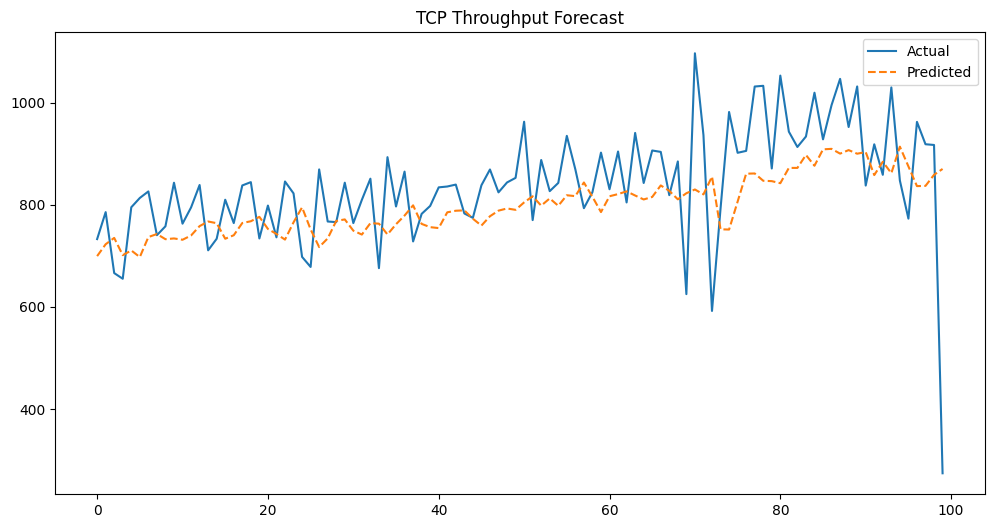

In [42]:
# Plotting the last 5 seconds of the test set
plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled[-100:], label='Actual')
plt.plot(y_pred_rescaled[-100:], label='Predicted', linestyle='--')
plt.title("TCP Throughput Forecast")
plt.legend()
plt.show()